In [1]:
from prelude import *
import pandas as pd
import nltk
from nltk.stem import PorterStemmer

In [2]:
conf = SparkConf().setAppName("question5-8").setMaster("local[*]")
sc = SparkContext(conf=conf)
spark = SparkSession(sc)
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)
lines = sc.textFile('../data/English/')
lines = lines.map(lambda line: json.loads(line))

In [3]:
# see the 20 most fequent hashtags 

def get_all_hashtags(s):
    hashtags = s['entities']['hashtags']
    res = []
    for hashtag in hashtags:
        res.append((hashtag['text'], 1))
    return res


lines.flatMap(get_all_hashtags).reduceByKey(lambda a, b: a + b).sortBy(lambda x: x[1], ascending = False).take(20)

[('AsimForTheWin', 54334),
 ('AsimRiaz', 4088),
 ('BossBirthdayCDP', 3688),
 ('iHeartAwards', 3150),
 ('ShehnazKaur', 2870),
 ('AsliFans', 2612),
 ('BTS', 2492),
 ('BB13OnVoot', 2331),
 ('BB13', 1806),
 ('BiggBoss13', 1733),
 ('SidharthShukla', 1450),
 ('WONPOCALYPSE', 1368),
 ('Budget2020', 1310),
 ('BestMusicVideo', 1167),
 ('HAPPYDOYOUNGDAY', 1158),
 ('AWKJSJFKSJFLA', 1118),
 ('NCT', 1033),
 ('NCT127', 998),
 ('Brexit', 997),
 ('DOYOUNG', 966)]

## Question 4
Task: Anomaly detection in time series.

We implement the simple poisson method, using the count of previous data point as the mean.

In [39]:
'''
alpha: float, confidence level
target_hashtag: string, the hashtag to perform anomaly detection on 
target_eta: float, threshold for anomaly detection
time_interval_x : int, time interval for a single data point to count hashtags
'''

alpha = 0.99
target_hashtag = 'BiggBoss13'
target_eta = 1.1
time_interval_day = 0
time_interval_hour = 1
time_interval_minute = 0
time_interval_second = 0

date_time_begin_str = 'Fri Jan 31 23:00:00 +0000 2020'
date_time_end_str = 'Sat Feb 01 23:30:00 +0000 2020'
date_time_pattern = '%a %b %d %H:%M:%S %z %Y'
df_date_time_pattern = '%Y-%m-%d %H:%M:%S'

date_time_begin_obj = datetime.datetime.strptime(
    date_time_begin_str, date_time_pattern)
date_time_end_obj = datetime.datetime.strptime(
    date_time_end_str, date_time_pattern)

delta_time = datetime.timedelta(
     seconds=time_interval_second,
     minutes=time_interval_minute,
     hours=time_interval_hour,
     days=time_interval_day,
     )
STOP_WORDS_PATH = 'helper_data/stop_words_english.txt'

In [9]:
# see content of one row
lines.take(1)

[{'created_at': 'Fri Jan 31 22:59:55 +0000 2020',
  'id': 1223380418189299714,
  'id_str': '1223380418189299714',
  'text': "@Yazidinhok ptdrrrrrrrrr je sais que c'est du cinema fast-food mais bon même pas un sur les 150 000 sortis, c'est abusé",
  'display_text_range': [12, 119],
  'source': '<a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>',
  'truncated': False,
  'in_reply_to_status_id': 1223379548525531136,
  'in_reply_to_status_id_str': '1223379548525531136',
  'in_reply_to_user_id': 3435541767,
  'in_reply_to_user_id_str': '3435541767',
  'in_reply_to_screen_name': 'Yazidinhok',
  'user': {'id': 1039569053428469760,
   'id_str': '1039569053428469760',
   'name': 'Walid.',
   'screen_name': 'walid_srh',
   'location': 'Paris, France',
   'url': 'https://twitter.com/warriors/status/741477884888391681?s=21',
   'description': '| W.Y | ceux qui manquent sont déjà partis | T.C.O',
   'translator_type': 'none',
   'protected': False,
   'verified': False,
   'fo

In [6]:
def get_time_period(t, time_bucket_size, time_start_at):
    '''
    Convert a time point to its belonging time period. The time periods start at time_start_at, with size of time_bucket_size
    input:
        t: string, time point
        time_bucket_size: datetiem.timedelta
        time_start_at: datetime.datetime
    
    return:
        date_time_time_period_str: string, the time period the tweet created at
    '''
    curr_datetime = datetime.datetime.strptime(
        t, date_time_pattern)
    date_time_time_period = ((curr_datetime - time_start_at)//time_bucket_size) * time_bucket_size + time_start_at
    date_time_time_period_str = date_time_time_period.strftime(df_date_time_pattern)
    return date_time_time_period_str


def get_time_period_for_row(s, time_bucket_size, time_start_at):
    '''
    Assign the created time period to a tweet. The time periods start at time_start_at, with size of time_bucket_size
    input:
        s: row in RDD
        time_bucket_size: datetiem.timedelta
        time_start_at: datetime.datetime
    
    return:
        date_time_time_period_str: string, the time period the tweet created at
        (date_time_time_period_str, 1)
    '''
    date_time_time_period_str = get_time_period(s['created_at'], time_bucket_size, time_start_at)
    s['created_at_time_period'] = date_time_time_period_str
    return s
    
    
def filter_hashtag(s, target_hashtag):
    '''
    Filter the tweet who contains target_hashtag
    '''
    hashtags = list(map(lambda h: h['text'], s['entities']['hashtags']))
    return target_hashtag in hashtags

In [8]:
# filter the tweet with target hashtag
tweet_with_hashtag = lines.filter(lambda s: filter_hashtag(s, target_hashtag)).map(lambda s: get_time_period_for_row(s, delta_time, date_time_begin_obj))

In [9]:
# get the count of tweet with target hashtag within a time inteval
hashtag_trend = tweet_with_hashtag.map(lambda s: (s['created_at_time_period'], 1)).reduceByKey(lambda a, b: a + b)

In [10]:
# convert the result into pandas(the size is already small enough)
hashtag_trend_df = spark.createDataFrame(hashtag_trend,schema=['t', 'hashtag_count']).toPandas()

In [140]:
hashtag_trend_df

,hashtag_count,eta
t,,
2020-01-31 23:00:00,9.0,0.000000
2020-02-01 00:00:00,4.0,0.312500
2020-02-01 01:00:00,15.0,1.100000
2020-02-01 02:00:00,22.0,0.350000
2020-02-01 03:00:00,32.0,0.416667
2020-02-01 04:00:00,38.0,0.206897
2020-02-01 05:00:00,26.0,0.375000
2020-02-01 06:00:00,38.0,0.461538
2020-02-01 07:00:00,114.0,2.375000


In [11]:
# convert the format of t
hashtag_trend_df['t'] = pd.to_datetime(hashtag_trend_df['t']).dt.strftime(df_date_time_pattern)
hashtag_trend_df = hashtag_trend_df.set_index('t')

In [12]:
from pandas.tseries.offsets import DateOffset

# Create dataframe with full time intervals index 
#(at some time intervals, the tweet count is 0, so no row in hashtag_trend_df to represent this time interval) 
time_index = pd.date_range(start=date_time_begin_obj, end=date_time_end_obj, freq = delta_time, name='t').strftime(df_date_time_pattern)
full_time_index_df = pd.DataFrame(index = time_index)

In [13]:
# Fill in the hashtag_trend_df with full time intervals index 
hashtag_trend_df = full_time_index_df.join(hashtag_trend_df).fillna(0).reset_index()

In [14]:
hashtag_trend_df

,t,hashtag_count
0,2020-01-31 23:00:00,9.0
1,2020-02-01 00:00:00,4.0
2,2020-02-01 01:00:00,15.0
3,2020-02-01 02:00:00,22.0
4,2020-02-01 03:00:00,32.0
5,2020-02-01 04:00:00,38.0
6,2020-02-01 05:00:00,26.0
7,2020-02-01 06:00:00,38.0
8,2020-02-01 07:00:00,114.0
9,2020-02-01 08:00:00,113.0


In [15]:
import scipy.stats.distributions as dists

# Calculate eta for each data point

def get_eta(row):
    
    # use simple poisson model, mean = count of the previous point
    # inspired by the code https://github.com/twitterdev/Gnip-Trend-Detection/blob/master/gnip_trend_detection/models.py
    
    index = row.name
    if index == 0:
        return 0
    else:
        last_count = hashtag_trend_df.loc[index-1].hashtag_count
        
    current_count = row.hashtag_count

    if last_count == 0 or current_count == 0:
        return 0

    Delta_r = abs(current_count - last_count) 
    sensitivity = float(Delta_r)/last_count 
    delta_r = dists.poisson.interval(alpha,last_count)[1] - dists.poisson.interval(alpha,last_count)[0]
    relative_confidence_interval = delta_r/last_count
    return sensitivity/relative_confidence_interval


hashtag_trend_df['eta'] = 0.
hashtag_trend_df['eta'] = hashtag_trend_df.apply(get_eta, axis=1)

In [16]:
hashtag_trend_df = hashtag_trend_df.set_index('t')
hashtag_trend_df

,hashtag_count,eta
t,,
2020-01-31 23:00:00,9.0,0.000000
2020-02-01 00:00:00,4.0,0.312500
2020-02-01 01:00:00,15.0,1.100000
2020-02-01 02:00:00,22.0,0.350000
2020-02-01 03:00:00,32.0,0.416667
2020-02-01 04:00:00,38.0,0.206897
2020-02-01 05:00:00,26.0,0.375000
2020-02-01 06:00:00,38.0,0.461538
2020-02-01 07:00:00,114.0,2.375000


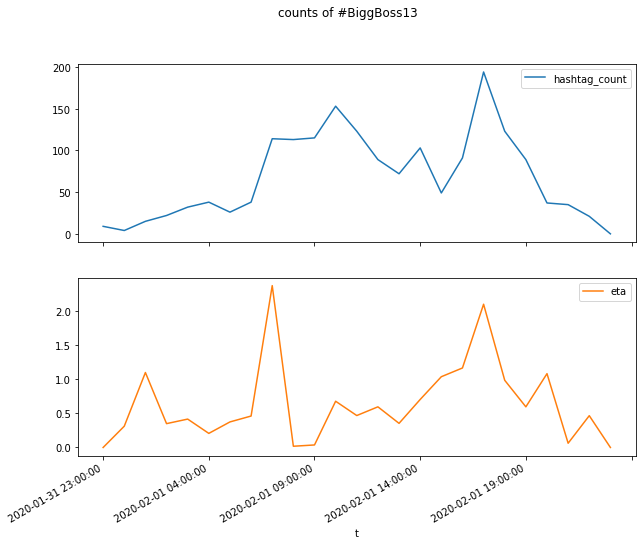

In [17]:
axes = hashtag_trend_df.plot.line(subplots=True, title = 'counts of #' + target_hashtag, figsize = (10,8))

In [40]:
# Show the data point with anomalies
event_intervals = hashtag_trend_df[hashtag_trend_df.eta > target_eta].index.tolist()
event_intervals

['2020-02-01 07:00:00', '2020-02-01 16:00:00', '2020-02-01 17:00:00']

## Question 5
Task: Find frequent words that together describe an event.

To do this, we filter the tweets with anomaly trend, and find their most frequent words.

In [41]:
# filter tweet with target hashtag and within the event intervals

tweet_at_event = tweet_with_hashtag.filter(lambda s: s['created_at_time_period'] in event_intervals).cache()

In [22]:
tweet_at_event.take(5)

[{'created_at': 'Sun Feb 02 19:02:54 +0000 2020',
  'id': 1224045546706354176,
  'id_str': '1224045546706354176',
  'text': 'RT @ThDarkJedi_: #polqc #polcan #cdnpoli #plc #pcc #npd #bloc #assnat #caq #qs #pq #plq #SuperBowlnaESPN #SuperBowl #Subventions Nos médias…',
  'source': '<a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>',
  'truncated': False,
  'in_reply_to_status_id': None,
  'in_reply_to_status_id_str': None,
  'in_reply_to_user_id': None,
  'in_reply_to_user_id_str': None,
  'in_reply_to_screen_name': None,
  'user': {'id': 708908492359225345,
   'id_str': '708908492359225345',
   'name': 'Richard Lambert',
   'screen_name': 'lambert_pp',
   'location': 'Canada',
   'url': None,
   'description': 'Veteran.signed the dotted line.CANADA WAKE UP.Fight for the right.or lose it.your choice .',
   'translator_type': 'none',
   'protected': False,
   'verified': False,
   'followers_count': 2195,
   'friends_count': 4997,
   'listed_count': 4,
   'favourites

In [45]:

ps = PorterStemmer()
# Get the most frequent words at event
with open(STOP_WORDS_PATH, 'r', encoding='utf-8') as f:
    stop_words = [i.strip() for i in f.readlines()]
stop_words.extend(['rt', ':', '?', ',', '.', '!',
                   '-', '_', '/', '»', '«', '&amp;'])
def filter_tweet_special_text(word):
    if word == 'RT'or word.startswith('@') or word.startswith('http'):
        return False
    return True

words_at_event = tweet_at_event.flatMap(lambda s: ps.stem(s['text']).strip().split())\
                .filter(lambda s: filter_tweet_special_text(s) and s not in stop_words)
most_frequent_words_at_event = words_at_event.map(lambda x: (x, 1))\
    .reduceByKey(lambda a, b: a + b)\
    .map(lambda s: (s[1], s[0]))\
    .sortByKey(False).take(20)

In [46]:
most_frequent_words_at_event

[(380, '#biggboss13'),
 (175, '#bb13'),
 (93, '#asimriaz'),
 (63, 'support'),
 (60, '#asimforthewin'),
 (49, 'asim'),
 (42, 'fans'),
 (42, 'journey'),
 (41, '#shehnaazgill'),
 (40, 'love'),
 (40, 'winner'),
 (36, '#biggboss'),
 (34, 'all.'),
 (34, 'winner!!!'),
 (34, 'doubt'),
 (33, 'sureshot'),
 (33, 'proved'),
 (33, '#siddharthshukla'),
 (33, 'praise'),
 (32, 'boss')]

## Question 6
Task: Get the timeframe of the event.

To do this, we do text summarization for the tweet with anomaly trend.   

In [48]:
sentences_at_event = tweet_at_event.map(lambda s: (s['created_at_time_period'], s['text'])).reduceByKey(lambda a,b: a + '. ' + b).cache()
# sentences_at_event_list: [(created_at_time_period, text)]
sentences_at_event_list = sentences_at_event.collect()

In [108]:
# get the text of tweets at event

ps = PorterStemmer()
n_top_sentence = 2


def summarize(text, n_top_sentence, tweet_stop_words):
    # code inspired by https://www.kaggle.com/imkrkannan/text-summarization-with-nltk-in-python 
    # and https://becominghuman.ai/text-summarization-in-5-steps-using-nltk-65b21e352b65
    '''
    text: string
    n_top_sentence: use the n most important sentences to summarize
    '''
    sentence_list = nltk.sent_tokenize(text)
    sentence_list = [newsent + '.' for sent in sentence_list for newsent in sent.split('\n') ] 
    sentence_list = [' '.join([word for word in sent.split(' ') if filter_tweet_special_text(word)]) for sent in sentence_list]
    tweet_stop_words.extend(['#', "’", '.'])
    
    word_frequencies = {}
    for sent in sentence_list:
        for word in nltk.word_tokenize(sent.lower()):
            if word not in tweet_stop_words:
                if word not in word_frequencies.keys():
                    word_frequencies[word] = 1
                else:
                    word_frequencies[word] += 1
        
    sentence_scores = {}
    sentence_labels = {}
    for sent in sentence_list:
#         print('--------------------------------')
#         print(sent)
        sent_label = sent[:15]
        if sent_label not in sentence_labels:
            sentence_labels[sent_label] = True
            sentence_scores[sent] = 0
            for word in nltk.word_tokenize(sent.lower()):
                if word in word_frequencies.keys():
#                     print(word, word_frequencies[word])
                    sentence_scores[sent] += word_frequencies[word]
#             print('sent score', sentence_scores[sent_label])

    sentence_sorted = sorted(sentence_scores.items(), key=lambda x: x[1], reverse=True)
    
    summary = ''
    
    for i in range(n_top_sentence):
        summary += sentence_sorted[i][0].replace('&amp;', '&') + '. '

    return summary



In [109]:
sentences_at_event_list = sorted(sentences_at_event_list, key = lambda x: x[0])

summary_at_event = {}
for item in sentences_at_event_list:
    event_time = item[0]
    text = item[1]
    summary = summarize(text, n_top_sentence, tweet_stop_words = stop_words)
    summary_at_event[event_time] = summary
    print('At {}: \n {}'.format(event_time, summary))
    print()

At 2020-02-01 07:00:00: 
 All praise  to the fans of Asim who have proved in his journey in #BiggBoss13  that their love & support has playe…... Vikas Gupta entered #BiggBoss13 in support of Sid  & tried to play dirty game by dragging  innocent girl Sharuti T…... 

At 2020-02-01 16:00:00: 
 #BiggBoss13: Prior to #SalmanKhan ’s #WeekendKaVaar, #AsimRiaz ’s fans show support & trend #AsimForTheWin’ -. Vikas Gupta entered #BiggBoss13 in support of Sid  & tried to play dirty game by dragging  innocent girl Sharuti T…... 

At 2020-02-01 17:00:00: 
 #BiggBoss13 #BiggBoss #Asim #AsimRiaz #Shukla #SiddharthShukla #ShehnazKaur #S…... Sana was a potential winner of #BiggBoss13 but because of obsession with Siddhart Shukla she looks really bad, flipper & no…... 



## Question 7
Task: Find the location of the events

To do this, we extract the location property of all event related tweets.

In [50]:
# get the location of tweets at event
locations_at_event = tweet_at_event.filter(lambda s: 'user' in s and 'location' in s['user'])\
    .map(lambda s: (s['user']['location'], 1))\
    .reduceByKey(lambda a,b: a + b)\
    .sortBy(lambda x: x[1], ascending = False).take(20)

In [51]:
locations_at_event

[(None, 246),
 ('India', 35),
 ('Mumbai, India', 10),
 ('New Delhi, India', 9),
 ('Hyderabad, India', 5),
 ('india', 4),
 ('Nepal', 3),
 ('Gondal, India', 2),
 ('Gujarat, India', 2),
 ('मुंबई, भारत', 2),
 ('Bengaluru, India', 2),
 ('Dhaka, Bangladesh', 2),
 ('Delhi, India', 2),
 ('Delhi', 2),
 ('Tikathali, Lalitpur', 1),
 ('United Kingdom', 1),
 ('Gurgaon, India', 1),
 ('Dehradun ', 1),
 ('Punjab, India', 1),
 ('Tata Steel City, Jamshedpur', 1)]

## Question 8
Include NLP task: sentiment around the event

We use vader to implement sentiment analysis.

In [126]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def get_sentiment_scores(text):
    '''
    Get sentiment scores for text
    input: 
        text: string
    return:
        sentiment_scores: list<float>
    '''
    sentiment_scores = []
    sentence_list = nltk.sent_tokenize(text)
    sentence_list = [newsent + '.' for sent in sentence_list for newsent in sent.split('\n') ] 
    sentence_list = [' '.join([word for word in sent.split(' ') if filter_tweet_special_text(word)]) for sent in sentence_list]
    analyzer = SentimentIntensityAnalyzer()
    for sentence in sentence_list:
        vs = analyzer.polarity_scores(sentence)
        sentiment_scores.append(vs['compound'])
    return sentiment_scores

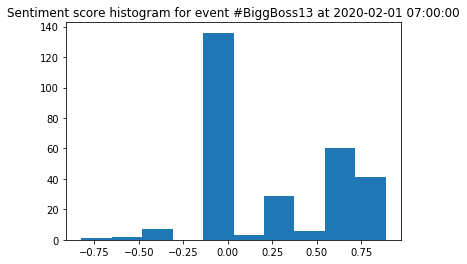

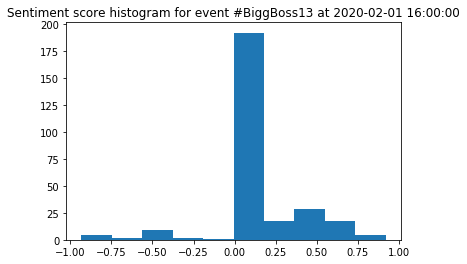

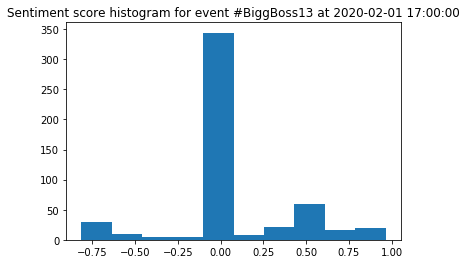

In [129]:
import matplotlib.pyplot as plt

for item in sentences_at_event_list:
    sentiment_scores = get_sentiment_scores(item[1])
    plt.figure()
    plt.hist(sentiment_scores)
    plt.title('Sentiment score histogram for event #{} at {}'.format(target_hashtag, item[0]))

In [53]:
def get_entities(text):
    entities = {}
    for sentence in nltk.sent_tokenize(text):
        # classifier chunk the sentences, adds category labels, e.g. PERSON
        trees = nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sentence)))
        # select only trees with the kinds of entities we want
        for tree in trees:
            if hasattr(tree, 'label'):
                label = tree.label()
                for t in tree:
                    entity = t[0]
                    if label in entities:
                        if entity not in entities[label]:
                            entities[label].append(entity)
                    else:
                        entities[label] = [entity]

    return entities 

In [138]:
full_text_at_event = ''
for item in sentences_at_event_list:
    full_text_at_event += item[1] + ' '
entities = get_entities(full_text_at_event)

Entity type  ORGANIZATION
AsimForTheWin, BiggBoss13, SidharthShukla, BB13, AssimRiaz, Ki, MahiraSharma, Vs, KunalAdityaSingh, Fight, SiddharthShukla, AsimRiaz, Gon, CHEERS, SidHearts, Asim, KingAsim, Sid, Pie, Winner, ShehbaazOnFire, ParasChhabra, HimanshiKhurana, National, BiggBoss, RashmiDesai, DevoleenaBhattacharjee, BOTS, Audiance, HimanshiKhurrana, ColorsTV, ShehnaazGill, ShefaliZeherwala, AsimRiazForTheWin, SHUT, UNSEEN, BB11, SidVik, VikasGupta, VikasInBB13, Vivo_India, PureHeartedRashami, LOTS, LOVE, RASHMI, ASIm, Fame, CHUKLA, TVQueenRashamiDesai, VishalAdityaSingh, SalmanKhan, WeekendKaVaar, NOMINATIONS, CheaterBiggBoss13, Shitnaaz, Hiten, Tejwani, Interview, For, His, Latest, SidharthShukIa, HinaKhan, ShehnazForTheWin, ShehnazKaur, SherniSana, BB13OnVoot, AADA, Currently, Playful, Tasks, With, Guests, BLOODY, ArtiSingh005, DaburAnmol, SiddharthSukla, Shehnaaz, Gill, BeingSalmanKhan, Always, ShehnaazGilll, ParasChabbra, Reality, GrandFinale, ArtiSingh, Nomination, RazaRayees,

In [139]:
for entity_type in entities:
    print('Entity type ', entity_type, ': ')
    print(', '.join(entities[entity_type]))
    print()

Entity type  ORGANIZATION : 
AsimForTheWin, BiggBoss13, SidharthShukla, BB13, AssimRiaz, Ki, MahiraSharma, Vs, KunalAdityaSingh, Fight, SiddharthShukla, AsimRiaz, Gon, CHEERS, SidHearts, Asim, KingAsim, Sid, Pie, Winner, ShehbaazOnFire, ParasChhabra, HimanshiKhurana, National, BiggBoss, RashmiDesai, DevoleenaBhattacharjee, BOTS, Audiance, HimanshiKhurrana, ColorsTV, ShehnaazGill, ShefaliZeherwala, AsimRiazForTheWin, SHUT, UNSEEN, BB11, SidVik, VikasGupta, VikasInBB13, Vivo_India, PureHeartedRashami, LOTS, LOVE, RASHMI, ASIm, Fame, CHUKLA, TVQueenRashamiDesai, VishalAdityaSingh, SalmanKhan, WeekendKaVaar, NOMINATIONS, CheaterBiggBoss13, Shitnaaz, Hiten, Tejwani, Interview, For, His, Latest, SidharthShukIa, HinaKhan, ShehnazForTheWin, ShehnazKaur, SherniSana, BB13OnVoot, AADA, Currently, Playful, Tasks, With, Guests, BLOODY, ArtiSingh005, DaburAnmol, SiddharthSukla, Shehnaaz, Gill, BeingSalmanKhan, Always, ShehnaazGilll, ParasChabbra, Reality, GrandFinale, ArtiSingh, Nomination, RazaRaye